<a id="top"></a>
# Iguazio Tutorial: Getting Started

This tutorial is designed to provide an overview of Iguazio's Data Science platform capabilities. <br>
In this tutorial we would go over a basic ML workflow comprised of the following steps:
1. [Create project & Set Configurations](#step1)
2. [Data Acquisition](#step2)
3. [Data Exploration](#step3)
4. [Run model training at scale](#step4)
5. [Model testing](#step5)
6. [Create a Fully Automated ML Pipeline](#step6)

By the end of this tutorial you will learn how to:
1. Create a new project
2. Create functions and track experiments while running them 
3. Store artifacts to be used and managed in a central database
4. Leverage the Iguazio functions marketplace 
5. Create an automated pipeline
6. Run your code on a distributed cluster without any DevOps
7. Create a scalable endpoint for model serving


For this example we will use the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set). This is a well-known dataset that is widely used for basic tutorials, such as this. The dataset contains a set of 150 records under five attributes - petal length, petal width, sepal length, sepal width and species. Our model will classify the species based on the other four attributes.

<a id="step1"></a>
# Step 1: Create Project & Set Configurations

## Create a New Project
Projects are used to package multiple functions, workflows, and artifacts. We usually store project code and definitions in a Git archive.

Set the base `project` directory in the same folder as this notebook. All the projects deliverables reside under the project directory.

The project folder is structured as follows:
- `project.yaml` containing the project definitions
- Additional generated python code

After setting the `project_path` and the `project_name`, call `new_project` to create the project

In [1]:
from os import path
from mlrun import new_project
project_path = path.abspath('conf')
project_name = 'getting-started-iris'
project = new_project(project_name, project_path, init_git=True)

print(f'Project path: {project_path}')

Project path: /User/demos/getting-started-tutorial/conf


## MLRun configuration

MLRun is a generic and convenient mechanism for data scientists and software developers to describe and run tasks related to machine learning (ML) in various, scalable runtime environments and ML pipelines while automatically tracking executed code, metadata, inputs, and outputs. MLRun integrates with the Nuclio serverless project and with Kubeflow Pipelines.

> **Note**:
>
> As a pre-requisite, the MLRun service must be installed in the cluster. For more information, reach out to support@iguazio.com

Now we'll set the artifact path. artifacts from each run are stored in the `artifact_path` which can be set globally through environment var (`MLRUN_ARTIFACT_PATH`) or through the config, if it's not already set we can create a directory and use it in our runs. Using `{{run.uid}}` in the path will allow us to create a unique directory per run, but we are not using this option in this demo. When we use pipelines, we can use the `{{workflow.uid}}` template option to create a directory for each iteration. When running jobs as standalone jobs the data and artifacts will be saved under the `jobs` folder under the `project name` directory. Later in the notebook we will create a full pipeline, in this case the artifacts will be stored in the `pipeline` directory.

Within the artifacts directory you will find 3 folders:
- `data` to store any information, such as dataframes
- `plots` to store images, figures, and plotlines
- `models` to store any trained models

In [2]:
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io
artifact_path = path.abspath('jobs') # specify artifacts target location
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

Artifacts path: /User/demos/getting-started-tutorial/jobs
MLRun DB path: http://10.194.195.75:8080


## Specify nuclio imports
You will see throughout this notebook nuclio commands and comments related to the code generation. Nuclio is used for annotating the notebook in order to automate the function generation.

In [3]:
import nuclio

In [4]:
# nuclio: start-code

**Specify function dependencies and configuration**

In [5]:
%nuclio config spec.image = "mlrun/ml-models"
%nuclio config kind = "job"

%nuclio: setting spec.image to 'mlrun/ml-models'
%nuclio: setting kind to 'job'


<a id="step2"></a>
# Step 2: Data Acquisition
We will download the data from AWS S3 bucket into Iguazio file system and store it as an MLRun dataset

Set the source data URL.

In [6]:
# nuclio: ignore
source_url = 'http://iguazio-sample-data.s3.amazonaws.com/iris_dataset.csv'

In [7]:
from os import path
import pandas as pd

def get_data(context, source_url, format='csv'):

    iris_dataset = pd.read_csv(str(source_url))
    
    target_path=path.join(context.artifact_path, 'data')
    # We can print out data to our logger
    context.logger.info('saving iris dataframe to {}'.format(target_path))
    
    # Store the dataset in the artifact database
    context.log_dataset('iris_dataset', df=iris_dataset, format=format, index=False, artifact_path=target_path)

The following end-code annotation tells ```nuclio``` to stop parsing the notebook from this cell. _**Please do not remove this cell**_:

In [8]:
# nuclio: end-code
# marks the end of a code section

<a id='test-locally'></a>
## Run the function locally

The functions above can be tested locally. Parameters, inputs, and outputs can be specified in the API or the `Task` object.<br>
When using `run_local()` the function inputs and outputs are automatically recorded by MLRun experiment and data tracking DB.

In each run we can specify the function, inputs, parameters/hyper-parameters, etc... For more details, see the `mlrun_basics` notebook.

In [9]:
# run the function locally
get_data_run = run_local(name='get_data',
                         handler=get_data,
                         inputs={'source_url': source_url},
                         project=project_name, artifact_path=artifact_path) 

[mlrun] 2020-04-19 10:56:45,860 starting run get_data-get_data uid=1c81ed4c53294eec8c7c7e8e4db33254  -> http://10.194.195.75:8080
[mlrun] 2020-04-19 10:56:46,305 saving iris dataframe to /User/demos/getting-started-tutorial/jobs/data
[mlrun] 2020-04-19 10:56:46,369 log artifact iris_dataset at /User/demos/getting-started-tutorial/jobs/data/iris_dataset.csv, size: 2776, db: Y



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...b33254,0,Apr 19 10:56:45,completed,get_data-get_data,kind=handlerowner=adminhost=jupyter-gilad-65449df545-p489s,source_url,,,iris_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1c81ed4c53294eec8c7c7e8e4db33254 --project getting-started-iris , !mlrun logs 1c81ed4c53294eec8c7c7e8e4db33254 --project getting-started-iris
[mlrun] 2020-04-19 10:56:46,439 run executed, status=completed


### Review the output

In the output you should be able to see the state of the execution, all the inputs and parameters as well as results and artifacts. If you click the on the artifact `iris_dataset` you will be get a quick glance of this dataset as displayed below
![getting_started-get_data-details](./assets/getting_started-get_data-details.png)

You can go to the MLRun UI and view the job status, getting information about the job, view the inputs, the artifacts, results, and log. Click on the `jobs` link of the current project, to see all the jobs and their status:

> Note
>
> To access the MLRun UI, you need to open a separate tab. The URL is usually your current app server on port `30088`.
>
> For example, if the current Jupyter URL is `jupyter.default-tenant.app.iguazeng.com`, then the MLRun URL would typically be `http://default-tenant.app.iguazeng.com:30088`

<br>

View the jobs under your project:
![ui-jobs-monitor](./assets/getting_started-ui-jobs-monitor.png)

<br><br>
Click on the job name to see its details:

![get-iris-data-ui-jobs](./assets/getting_started-get_data-ui-jobs.png)

View the artifacts dataset under the artifacts tab

![get-iris-data-ui-artifacts](./assets/getting_started-get_data-ui-artifacts.png)

## Run the function on the cluster

One of the key benefits of Iguazio platform is the ability to easily run any code on a distributed cluster to get better performance. In order to do that, we need to convert our notebook code to a function that can run on the cluster and for that we have a built-in function called `code_to_function`. <br>
The ability to create a function that can run on a cluster would also be useful once we'll create the automated pipeline.<br>
Let's run the `code_to_function`

In [10]:
from mlrun import code_to_function
gen_func = code_to_function(name='get-data')
project.set_function(gen_func)

Now the funciton is ready and we can run it on the cluster. instead of `run_local`, we'll just use `run`.<br>

In [11]:
get_data_func = project.func('get-data').apply(mount_v3io())
get_data_run = get_data_func.run(name='get_data',
                                 handler='get_data',
                                 inputs={'source_url': source_url},
                                 artifact_path=artifact_path)

[mlrun] 2020-04-19 10:56:49,436 starting run get_data uid=efd37fc6f2984215bd2842e24ff41649  -> http://10.194.195.75:8080
[mlrun] 2020-04-19 10:56:49,520 Job is running in the background, pod: get-data-2pm2n
[mlrun] 2020-04-19 10:57:02,467 saving iris dataframe to /User/demos/getting-started-tutorial/jobs/data
[mlrun] 2020-04-19 10:57:02,517 log artifact iris_dataset at /User/demos/getting-started-tutorial/jobs/data/iris_dataset.csv, size: 2776, db: Y

[mlrun] 2020-04-19 10:57:02,540 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...f41649,0,Apr 19 10:57:01,completed,get_data,host=get-data-2pm2nkind=jobowner=adminv3io_user=adi,source_url,,,iris_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run efd37fc6f2984215bd2842e24ff41649 --project getting-started-iris , !mlrun logs efd37fc6f2984215bd2842e24ff41649 --project getting-started-iris
[mlrun] 2020-04-19 10:57:08,826 run executed, status=completed


<a id=step3></a>
# Step 3: Data Exploration

As we all know, data exploration is a big part of the data science work. Below is a simple example of how to extract statistics and gain some insight about our data. In this case, we'll just read the dataframe and print some basic statistics.

In [12]:
df = pd.read_csv(get_data_run.outputs['iris_dataset'])

In [13]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [14]:
print(f'Total number of rows: {len(df)}')

Total number of rows: 150


In [15]:
df.groupby(['label']).describe()

sepal length (cm)                                              \
                  count   mean       std  min    25%  50%  75%  max   
label                                                                 
0                  50.0  5.006  0.352490  4.3  4.800  5.0  5.2  5.8   
1                  50.0  5.936  0.516171  4.9  5.600  5.9  6.3  7.0   
2                  50.0  6.588  0.635880  4.9  6.225  6.5  6.9  7.9   

      sepal width (cm)         ... petal length (cm)      petal width (cm)  \
                 count   mean  ...               75%  max            count   
label                          ...                                           
0                 50.0  3.428  ...             1.575  1.9             50.0   
1                 50.0  2.770  ...             4.600  5.1             50.0   
2                 50.0  2.974  ...             5.875  6.9             50.0   

                                                 
        mean       std  min  25%  50%  75%  max  
label                                            
0      0.246  0.105386  0.1  0.2  0.2  0.3  0.6  
1      1.326  0.197753  1.0  1.2  1.3  1.5  1.8  
2      2.026  0.274650  1.4  1.8  2.0  2.3  2.5  

[3 rows x 32 columns]

## Visualize dataset features and statistics

You can further explore the dataset by leveraging the **functions marketplace**. This marketplace is a centralized location for open source contributions of function components that are commonly used in machine learning development.
> **Note**: the function marketplace location is configurable, by default it points to `mlrun/functions` git

Let's load the function called `describe` from the function marketplace:

In [16]:
project.set_function('hub://describe', 'describe')
describe = project.func('describe').apply(mount_v3io())

We can now run the `describe` function as a Kubernetes job, the dataset is the only input we need.

If you'd like to, you can view the `describe` function code in the [**GitHub repository**](https://github.com/mlrun/functions/blob/master/describe/describe.ipynb).

For an additional list of functions available at the marketplace, refer to the [**functions marketplace GitHub repository main page**](https://github.com/mlrun/functions).

> **Note**:
> 
> `mount_v3io()` connects our function to v3io shared file system and allow us to pass the data and get back the results (plots) directly to our notebook, we can choose other mount options to use NFS or object storage.

In [17]:
describe_run = describe.run(params={'label_column': 'label'}, 
                            inputs={"table": get_data_run.outputs['iris_dataset']}, 
                            artifact_path=artifact_path)

[mlrun] 2020-04-19 10:57:09,402 starting run describe-summarize uid=2497c1cac5a7462a84139e01cd157df4  -> http://10.194.195.75:8080
[mlrun] 2020-04-19 10:57:09,517 Job is running in the background, pod: describe-summarize-7s7gf
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
[mlrun] 2020-04-19 10:57:28,668 log artifact histogram

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...157df4,0,Apr 19 10:57:24,completed,describe-summarize,host=describe-summarize-7s7gfkind=jobowner=adminv3io_user=adi,table,label_column=label,scale_pos_weight=1.00,histogramsimbalancecorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 2497c1cac5a7462a84139e01cd157df4 --project getting-started-iris , !mlrun logs 2497c1cac5a7462a84139e01cd157df4 --project getting-started-iris
[mlrun] 2020-04-19 10:57:31,858 run executed, status=completed


The `describe` function generates 3 artifacts: `histograms`, `imbalance` and `correlation`. You can view the output either by clicking the artifact in the output above or in the UI or by opening the HTML files as depicted below:


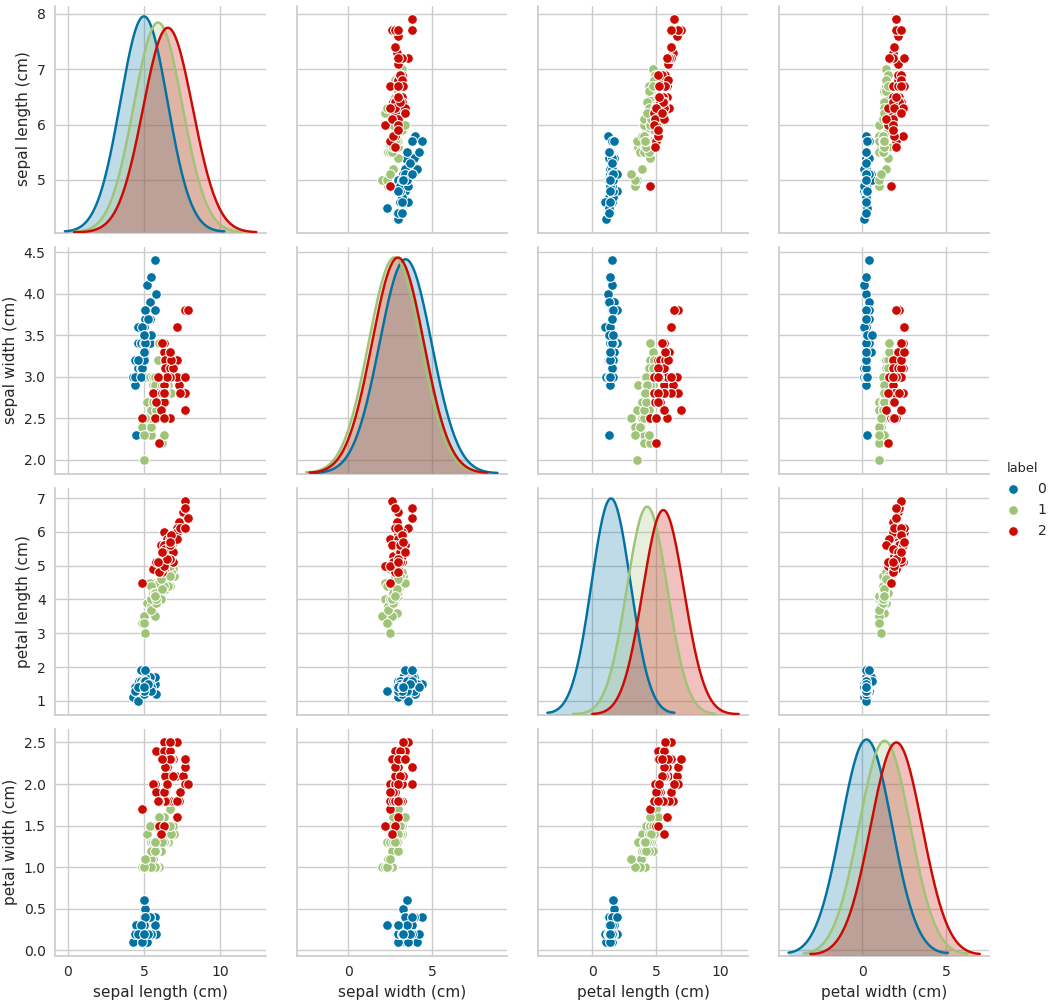

In [18]:
from IPython.display import display, HTML

display(HTML('<h3>Histograms</h3>'), HTML(describe_run.outputs['histograms']))


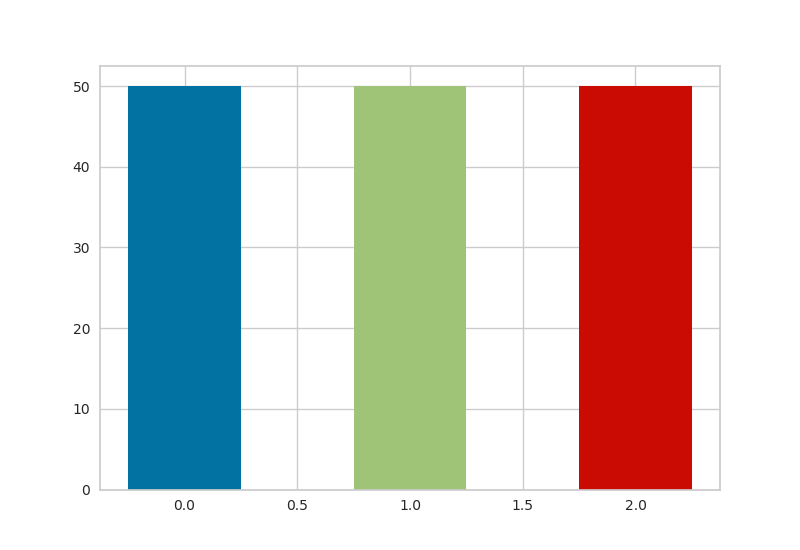

In [19]:
display(HTML('<h3>Imbalance<h3>'), HTML(filename=describe_run.outputs['imbalance']))


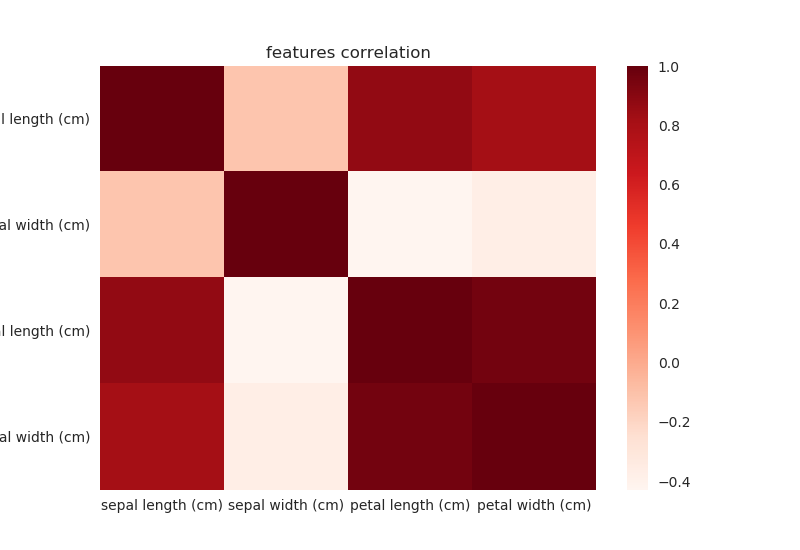

In [20]:
display(HTML('<h3>Correlation Matrix<h3>'), HTML(filename=describe_run.outputs['correlation']))

<a id=step4></a>
# Step 4: Run model training at scale
It's time to train the model, but which model type to choose from? The **function marketplace** has a function called `sklearn_classifier` which trains any scikit-learn model that you specify.

In [21]:
project.set_function('hub://sklearn_classifier', 'train')
train = project.func('train').apply(mount_v3io())

Specify the different models to train and evaluate. The model with the highest score would be selected

In [22]:
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

Perform the model training. In this case our training dataset will be 90% of the data and the remaining 10% will be the test dataset.

Notice that we have chosen to define `NewTask`. The advantage of tasks is that they are independent of the runtime. Hence, we can define tasks once and use them in different scenarios. In this example we define the training task basic input parameters, and then run the task with the list of models we would like to evaluate by using the `with_hyper_params` method.

In [23]:
train_task = NewTask(name="train",
                     params={"sample"          : -1, 
                             "label_column"    : "label",
                             "test_size"       : 0.10},
                     inputs={"dataset": get_data_run.outputs['iris_dataset']})
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                    selector='max.accuracy'),
                      artifact_path=artifact_path)

[mlrun] 2020-04-19 10:57:32,823 starting run train uid=ce41a791d6e241a798e1154df125f7ae  -> http://10.194.195.75:8080
[mlrun] 2020-04-19 10:57:32,965 Job is running in the background, pod: train-ch5fr
No handles with labels found to put in legend.
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
> --------------- Iteration: (1) ---------------
[mlrun] 2020-04-19 10:57:46,093 log artifact test_set at /User/demos/getting-start

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...25f7ae,0,Apr 19 10:57:43,completed,train,kind=jobowner=adminv3io_user=adi,dataset,label_column=labelsample=-1test_size=0.1,accuracy=0.9705882352941176best_iteration=2f1_score=0.9705882352941176rocauc=0.9945117845117846,test_setmodelrocconfusioniteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run ce41a791d6e241a798e1154df125f7ae --project getting-started-iris , !mlrun logs ce41a791d6e241a798e1154df125f7ae --project getting-started-iris
[mlrun] 2020-04-19 10:57:52,283 run executed, status=completed



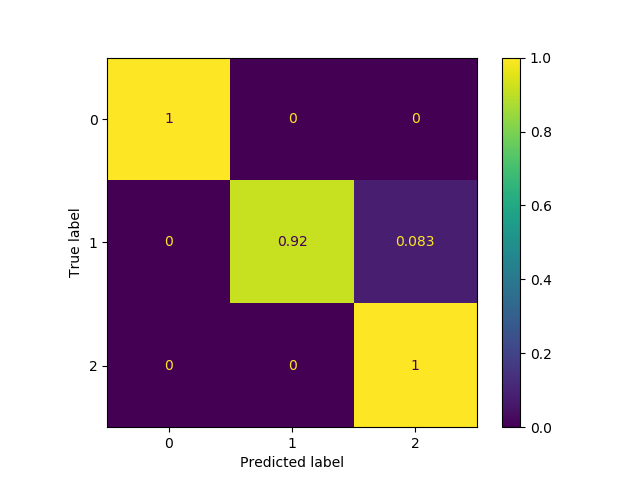


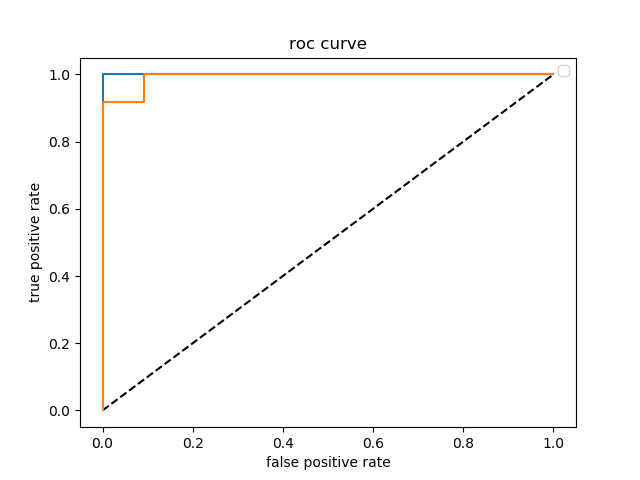

In [24]:
display(HTML(f'<b>Best model</b>: {models[train_run.outputs["best_iteration"]]}'))
display(HTML(f'<b>Accuracy</b>: {train_run.outputs["accuracy"]}'))
display(HTML('<h3>Confusion Matrix:</h3>'), HTML(filename=train_run.outputs['confusion']))
display(HTML('<h3>ROC Curve:</h3>'), HTML(filename=train_run.outputs['roc']))

<a id=step5></a>
# Step 5: Model testing

Now that we have a trained model, let's test it with the test dataset. Run the code below to run the selected trained model against the test dataset.

In [25]:
project.set_function('hub://test_classifier', 'test')
test = project.func('test').apply(mount_v3io())

In [26]:
test_task = NewTask(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path" : train_run.outputs['model'],
                            "test_set"    : train_run.outputs['test_set']}
                   )
test_run = test.run(test_task,
                    artifact_path=artifact_path)

[mlrun] 2020-04-19 10:57:52,932 starting run test uid=6ff47e80bbf94fb18d12990c38499227  -> http://10.194.195.75:8080
[mlrun] 2020-04-19 10:57:53,054 Job is running in the background, pod: test-9xn6f
No handles with labels found to put in legend.
[mlrun] 2020-04-19 10:58:08,500 log artifact roc at /User/demos/getting-started-tutorial/jobs/plots/test/roc.html, size: 31022, db: Y
[mlrun] 2020-04-19 10:58:08,677 log artifact confusion at /User/demos/getting-started-tutorial/jobs/plots/test/confusion.html, size: 19968, db: Y

[mlrun] 2020-04-19 10:58:08,697 run executed, status=completed
final state: succeeded


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...499227,0,Apr 19 10:58:08,completed,test,host=test-9xn6fkind=jobowner=adminv3io_user=adi,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=0.9333333333333333avg_precscore=0.3673982494785104f1_score=0.9333333333333333rocauc=0.3333333333333333,rocconfusion


to track results use .show() or .logs() or in CLI: 
!mlrun get run 6ff47e80bbf94fb18d12990c38499227 --project getting-started-iris , !mlrun logs 6ff47e80bbf94fb18d12990c38499227 --project getting-started-iris
[mlrun] 2020-04-19 10:58:12,321 run executed, status=completed



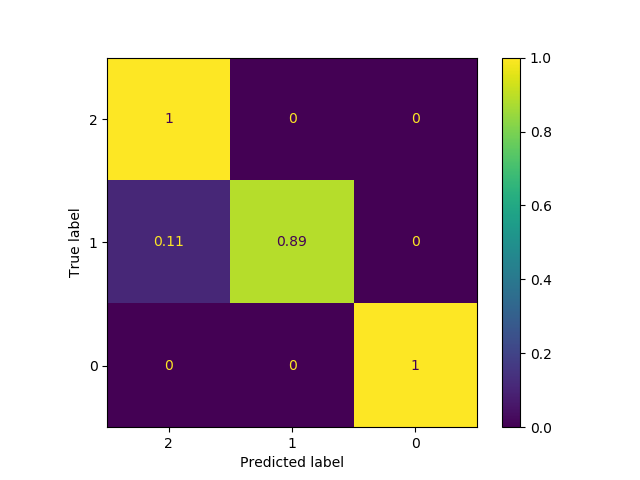


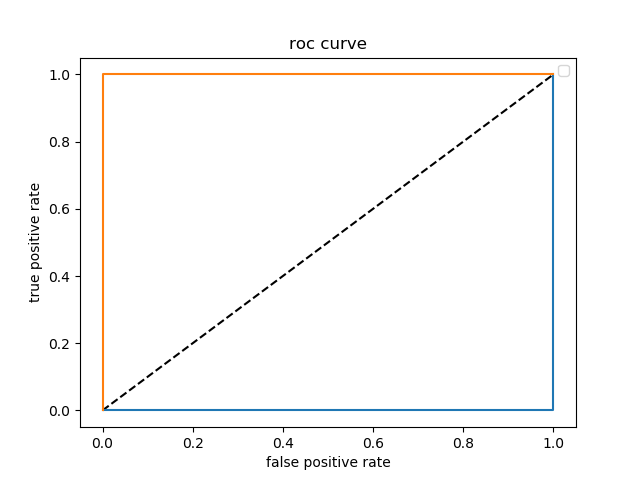

In [27]:
display(HTML(f'<b>Test Accuracy</b>: {test_run.outputs["accuracy"]}'))
display(HTML("<h3>Confusion matrix:</h3>"), HTML(filename=test_run.outputs['confusion']))
display(HTML("<h3>ROC Curve:</h3>"), HTML(filename=test_run.outputs['roc']))

<a id=step6></a>
# Step 6: Create a Fully Automated ML Pipeline

We are now ready to create a full pipeline. In order to do that are using a framework called Kubeflow Pipelines which is embedded in the Iguazio platform. Kubeflow pipeline is a framework for building and deploying portable, scalable machine learning (ML) workflows based on Docker containers. MLRun leverages this framework to take your existing code and deploy it as steps within the pipeline.

## Add serving functions from the marketplace

Add real-time model server and a model REST API Tester to our functions:

In [28]:
project.set_function('hub://model_server', 'serving')
project.set_function('hub://model_server_tester', 'serving-tester')

#### Define and save a pipeline 

The following workflow definition will be written into a file, it describes a Kubeflow execution graph (DAG)<br>
and how functions and data are connected  as part of an end to end pipeline. 

* Ingest the iris data
* Analyze the dataset (describe)
* Train and test the model
* Deploy the model as a real-time serverless function
* Test the serverless function REST API with test dataset

Check the code below to see how functions objects are initialized and used (by name) inside the workflow.<br>
The `workflow.py` file has two parts, initialize the function objects and define pipeline dsl (connect the function inputs and outputs).

> **Note**: the pipeline can include CI steps like building container images and deploying models.

In [29]:
%%writefile {path.join(project_path, 'workflow.py')}
from kfp import dsl
from mlrun import mount_v3io

funcs = {}
DATASET = 'iris_dataset'
LABELS  = "label"
MODELS = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

# init functions is used to configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(mount_v3io())
        
    functions['serving'].metadata.name = 'getting-started-serving'

    
@dsl.pipeline(
    name="Getting started tutorial",
    description="This tutorial is designed to provide an overview of Iguazio's Data Science platform capabilities.\n" + \
                "For this example we will use the Iris flower data set."
)
def kfpipeline(source_url = 'http://iguazio-sample-data.s3.amazonaws.com/iris_dataset.csv'):
    
    # run the ingestion function
    ingest = funcs['get-data'].as_step(
        name="get-data",
        handler='get_data',
        inputs={'source_url': source_url},
        params={'format': 'pq'},
        outputs=[DATASET])

    # analyze our dataset
    describe = funcs["describe"].as_step(
        name="summary",
        params={"label_column": LABELS},
        inputs={"table": ingest.outputs[DATASET]})
    
    # train with hyper-paremeters 
    train = funcs["train"].as_step(
        name="train",
        params={"sample"          : -1, 
                "label_column"    : LABELS,
                "test_size"       : 0.10},
        hyperparams={'model_pkg_class': MODELS},
        selector='max.accuracy',
        inputs={"dataset"         : ingest.outputs[DATASET]},
        outputs=['model', 'test_set'])

    # test and visualize our model
    test = funcs["test"].as_step(
        name="test",
        params={"label_column": LABELS},
        inputs={"models_path" : train.outputs['model'],
                "test_set"    : train.outputs['test_set']})

    # deploy our model as a serverless function
    deploy = funcs["serving"].deploy_step(models={f"{DATASET}_v1": train.outputs['model']})
    
    # test out new model server (via REST API calls)
    tester = funcs["serving-tester"].as_step(name='serving-tester',
        params={'addr': deploy.outputs['endpoint'], 'model': f"{DATASET}_v1"},
        inputs={'table': train.outputs['test_set']})

Writing /User/demos/getting-started-tutorial/conf/workflow.py


In [30]:
# register the workflow file as "main"
project.set_workflow('main', 'workflow.py')

Save the project definitions to a file (project.yaml), it is recommended to commit all changes to a Git repo.

In [31]:
project.save()

<a id='run-pipeline'></a>
## Run a pipeline workflow
Use the `run` method to execute a workflow, you can provide alternative arguments and specify the default target for workflow artifacts.<br>
The workflow ID is returned and can be used to track the progress or you can use the hyperlinks

> **Note**: The same command can be issued through CLI commands:<br>
    `mlrun project getting-started-iris -r main -p "v3io:///users/admin/demos/getting-started-tutorial/pipeline/{{workflow.uid}}/"`

The dirty flag allows us to run a project with uncommitted changes (when the notebook is in the same git dir it will always be dirty)

In [32]:
run_id = project.run(
    'main',
    arguments={}, 
    artifact_path=path.abspath(path.join('pipeline','{{workflow.uid}}')), 
    dirty=True)

[mlrun] 2020-04-19 10:58:13,694 Pipeline run id=e2fc8d6b-79c6-4b52-a221-e30deb2c4be2, check UI or DB for progress


Click on the **Experiments link** above to view experiment information.
![getting_started-pipeline](./assets/getting_started-pipeline-experiment.png)

Click on the **Run link** above to view the pipeline execution. When the run completes it should be as follows:
![getting_started-pipeline](./assets/getting_started-pipeline.png)

#### Track pipeline results

In [33]:
from mlrun import get_run_db
db = get_run_db().connect()
db.list_runs(project=project.name, labels=f'workflow={run_id}').show()

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...309712,0,Apr 19 10:59:29,completed,serving-tester,host=serving-tester-x45zqkind=jobowner=rootv3io_user=adminworkflow=e2fc8d6b-79c6-4b52-a221-e30deb2c4be2,table,addr=http://192.168.224.70:31314model=iris_dataset_v1,avg_latency=385252errors=0match=4total_tests=10,
...9ed309,0,Apr 19 10:59:20,completed,test,host=test-jflcqkind=jobowner=rootv3io_user=adminworkflow=e2fc8d6b-79c6-4b52-a221-e30deb2c4be2,models_pathtest_set,label_column=label,accuracy=0.9333333333333333avg_precscore=0.36663558663558665f1_score=0.9333333333333333rocauc=0.4343866010532677,rocconfusionfeatimpfeatimp-tbl
...afc0d8,0,Apr 19 10:58:53,completed,summary,host=summary-7m9jxkind=jobowner=rootv3io_user=adminworkflow=e2fc8d6b-79c6-4b52-a221-e30deb2c4be2,table,label_column=label,scale_pos_weight=1.00,histogramsimbalancecorrelation
...38222e,0,Apr 19 10:58:48,completed,train,kind=jobowner=rootv3io_user=adminworkflow=e2fc8d6b-79c6-4b52-a221-e30deb2c4be2,dataset,label_column=labelsample=-1test_size=0.1,accuracy=0.9705882352941176best_iteration=1f1_score=0.9705882352941176rocauc=0.9945117845117846,test_setmodelrocconfusioniteration_results
...0e2712,0,Apr 19 10:58:29,completed,get-data,host=get-data-27xmfkind=jobowner=rootv3io_user=adminworkflow=e2fc8d6b-79c6-4b52-a221-e30deb2c4be2,source_url,format=pq,,iris_dataset


You can now run the `getting-started-serving` function from the project screen. Add to the URL suffix `iris_dataset_v1/predict`, change the body type to `JSON` and add the following text to the request body:
```JSON
{"instances": [[5.1, 3.5, 1.4, 0.2]]}
```

The UI flow and expected output is displayed below:

![getting_started-pipeline](./assets/getting_started-model_serving_test.gif)

# Done

Congratulation!! You've completed your first tutorial on Iguazio platform !!!. <br>
To learn more go to the demos folder in your Jupyter home and check out our end to end demos.

**[back to top](#top)**